In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/stylegan2/

/content/drive/MyDrive/stylegan2


In [ ]:
#%%
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from keras import models
import keras.layers as kl
import matplotlib.pyplot as plt
import time
from IPython import display
from stylegan2_generator import StyleGan2Generator
from stylegan2_discriminator import StyleGan2Discriminator
from PIL import Image
import cv2

In [ ]:
resolution = 64
def resize_image(image):
    return tf.image.resize(image,(resolution,resolution))

buffer_size = 10
batch_size =1
x_train = (tf.keras.utils.image_dataset_from_directory("/content/drive/MyDrive/CeterisParibusDataset",labels=None,batch_size=batch_size)    
    .map(resize_image)
    .shuffle(buffer_size)
)

def define_encoder(im_shape):
    input = models.Input(shape=im_shape)
    x = kl.Conv2D(32,3,2,activation='relu',kernel_initializer='random_normal')(input)
    x = kl.Conv2D(64,3,2,activation='relu',kernel_initializer='random_normal')(x)
    x = kl.Conv2D(128,3,2,activation='relu',kernel_initializer='random_normal')(x)
    x = kl.Conv2D(256,3,2,activation='relu',kernel_initializer='random_normal')(x)
    x = kl.Flatten()(x)
    x = kl.Dense(512)(x)
    return models.Model(input,x)

Found 72 files belonging to 1 classes.


In [ ]:
dlatent_vector = (int(np.log2(resolution))-1)*2
weights_name = 'ffhq' 
generator = StyleGan2Generator(resolution=resolution,weights=weights_name, impl='ref')
decoder = generator
disc = StyleGan2Discriminator(resolution=resolution,weights=weights_name, impl='ref')

opt = keras.optimizers.Adam(1e-4)

Loaded ffhq generator weights!
Loaded ffhq discriminator weights!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1080x1080 with 0 Axes>

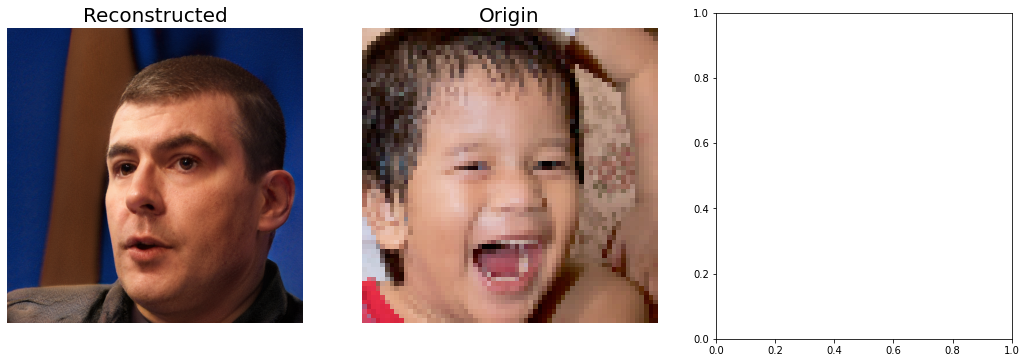

In [ ]:
epochs = 10
num_examples_to_generate = 2
im_shape = (resolution,resolution,3)
seed = tf.random.normal(shape=[num_examples_to_generate,512])
model = define_encoder(im_shape)

def generate_images(model,test_sample):
    z = model(test_sample)
    predictions = decoder(z)
    fig = plt.figure(figsize=(15,15))
    for i in range(predictions.shape[0]):
        grid_row = min(predictions.shape[0], 2)
        f, axarr = plt.subplots(grid_row, 2, figsize=(18, grid_row * 6))
        for row in range(grid_row):
            im = tf.transpose(predictions[i]).numpy()
            im = im.swapaxes(-3,-2)[...,::]
            ax = axarr
            ax[0].imshow(im*0.5+0.5)
            ax[0].axis("off")
            ax[0].set_title("Reconstructed", fontsize=20)
            ax[1].imshow(test_sample[0]/255)
            ax[1].axis("off")
            ax[1].set_title("Origin", fontsize=20)
    plt.show()

for test_batch in x_train.take(1):
    test_sample = test_batch[0:5,:,:,:]
generate_images(model,test_sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1080x1080 with 0 Axes>

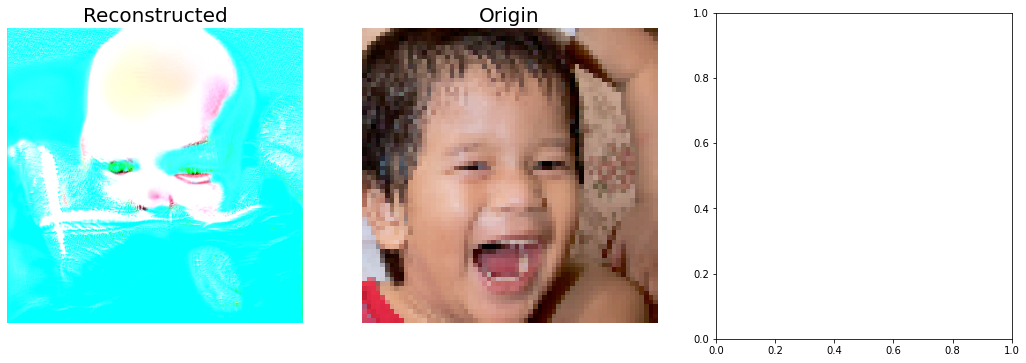

Epoch 12, Loss : 10559.96484375


KeyboardInterrupt: ignored

In [ ]:
def train_step(model,x,opt):
    with tf.GradientTape() as tape:
        z = model(x)
        xp = decoder(z)
        y = disc(xp)
        xp = tf.reshape(xp,(tf.shape(xp)[0],tf.shape(xp)[3],tf.shape(xp)[2],tf.shape(xp)[1]))
        xp = tf.image.resize(xp,(64,64))
        adloss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(y,tf.ones_like(y))
        loss = tf.reduce_mean(keras.losses.MSE(x,xp)) + adloss
    gradients = tape.gradient(loss,model.trainable_variables)
    opt.apply_gradients(zip(gradients,model.trainable_variables))
    return loss

for epoch in range(1,epochs+1+30):
    start_time = time.time()
    for batch in x_train:
        loss = train_step(model,batch,opt)
    end_time = time.time()
    display.clear_output(wait=False)
    generate_images(model,test_sample)
    print(f'Epoch {epoch}, Loss : {loss}')

model.encoder.save_weights('encoder_weights.h5')